# Inter-Maimi - PROD Retention Score
* StelllarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* June 20, 2022

In [3]:
import getpass
import pyodbc
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
from pycaret.classification import *

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [4]:
# connect to SQL Server.
SERVER = '34.206.73.189' 
DATABASE = 'datascience' 
USERNAME = 'dsAdminWrite' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

In [5]:
cursor = CNXN.cursor()

storedProc = (
    f"""Exec [mlsInterMiami].[ds].[getRetentionScoringModelData] 113 """
)

df = pd.read_sql(storedProc, CNXN)

# apply some data transformations
df["year"] = pd.to_numeric(df["year"])

CNXN.commit()
cursor.close()

df.shape

(6938, 17)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6938 entries, 0 to 6937
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   dimCustomerMasterId  6938 non-null   int64  
 1   year                 6938 non-null   int64  
 2   productGrouping      6938 non-null   object 
 3   email                6904 non-null   object 
 4   ticketingid          6938 non-null   object 
 5   totalSpent           6938 non-null   float64
 6   recentDate           6938 non-null   object 
 7   attendancePercent    6938 non-null   float64
 8   renewedBeforeDays    6938 non-null   int64  
 9   source_tenure        6938 non-null   int64  
 10  tenure               6938 non-null   int64  
 11  distToVenue          6693 non-null   float64
 12  recency              6938 non-null   int64  
 13  missed_games_1       6938 non-null   int64  
 14  missed_games_2       6938 non-null   int64  
 15  missed_games_over_2  6938 non-null   i

### We should specify the features used in our model:

In [7]:
# choose the features for the stellar base retention model
features = [
            "dimCustomerMasterId",
            "email",
            "ticketingid",
            "year",
            "productGrouping", 
            "totalSpent", 
            "recentDate",
            "attendancePercent", 
            "renewedBeforeDays",
            "source_tenure",
            "tenure",
            "distToVenue",
            "recency",
            "missed_games_1",
            "missed_games_2",
            "missed_games_over_2",
            "isNextYear_Buyer"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2021]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (3599, 17)
Unseen Data For Predictions: (635, 17)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [8]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=["dimCustomerMasterId","email","productGrouping","ticketingid","year"],
    silent=True,
    verbose=False,
    numeric_features=[
    "totalSpent", 
            "attendancePercent", 
            "renewedBeforeDays",
            "source_tenure",
            "tenure",
            "distToVenue",
            "recency",
            "missed_games_1",
            "missed_games_2",
            "missed_games_over_2"
    ]
);

In [9]:
model_matrix = compare_models(
    fold=10,
    include=["lightgbm"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.6384,0.7050,0.6790,0.6156,0.6454,0.2785,0.2802,0.7020


In [10]:
lightgbm_model = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6863,0.7626,0.7114,0.6667,0.6883,0.3732,0.3740
1,0.6275,0.7134,0.6242,0.6159,0.6200,0.2546,0.2547
2,0.6732,0.7413,0.7315,0.6450,0.6855,0.3482,0.3512
3,0.6340,0.7202,0.6622,0.6125,0.6364,0.2691,0.2699
4,0.6013,0.6583,0.6757,0.5747,0.6211,0.2062,0.2092
5,0.6601,0.7193,0.7027,0.6341,0.6667,0.3219,0.3236
6,0.5817,0.6463,0.6284,0.5602,0.5924,0.1657,0.1669
7,0.6601,0.7050,0.7365,0.6264,0.6770,0.3233,0.3280
8,0.6471,0.7045,0.6554,0.6299,0.6424,0.2943,0.2945
9,0.6131,0.6795,0.6622,0.5904,0.6242,0.2282,0.2298


### Let's load in our 2021 season data and get retention scores using the model:

In [11]:
df_inference = df.loc[df["year"] >= 2022]
df_inference = df_inference.fillna(0)
df_inference.shape

(2704, 17)

In [12]:
lightgbm_predictions = predict_model(lightgbm_model, data=df_inference, raw_score=True)

In [13]:
print(f"lightgbm:\n {lightgbm_predictions.Label.value_counts()}")

lightgbm:
 0    2312
1     392
Name: Label, dtype: int64


In [14]:
print(f"lightgbm:\n {lightgbm_predictions.Score_1.value_counts(bins=[0, 0.25, 0.5, 0.75, 1])}")

lightgbm:
 (-0.001, 0.25]    1492
(0.25, 0.5]        820
(0.5, 0.75]        306
(0.75, 1.0]         86
Name: Score_1, dtype: int64


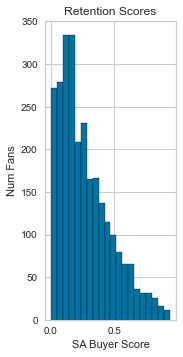

In [15]:
model_predictions = [lightgbm_predictions]

for idx, df_predictions in enumerate(model_predictions):

    plt.subplot(1, 3, idx+1)

    plt.hist(df_predictions["Score_1"], bins=20, edgecolor='black')
    plt.title("Retention Scores")
    plt.ylabel("Num Fans")
    plt.xlabel("SA Buyer Score")

plt.rcParams["figure.figsize"] = (20,4)
plt.show()

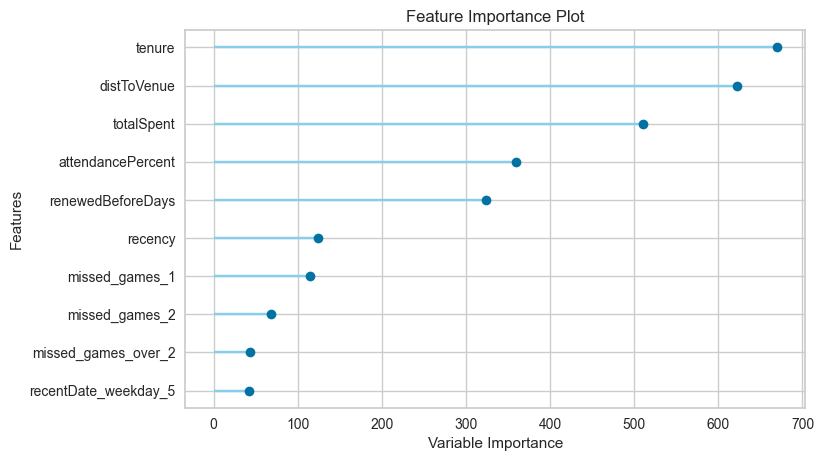

In [16]:
plot_model(lightgbm_model, plot='feature')

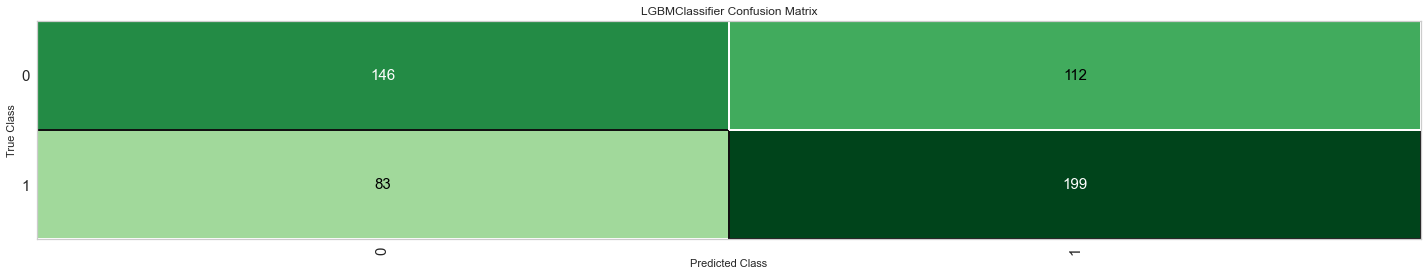

In [17]:
plot_model(lightgbm_model, plot='confusion_matrix')

In [18]:
lightgbm_predictions

,dimCustomerMasterId,year,productGrouping,email,ticketingid,totalSpent,recentDate,attendancePercent,renewedBeforeDays,source_tenure,tenure,distToVenue,recency,missed_games_1,missed_games_2,missed_games_over_2,isNextYear_Buyer,Label,Score_0,Score_1
0,46,2022,Flex Plan,195cleanup@gmail.com,270764,312.0,2022-07-13,0.88,10,730,150,38.20,0,0,0,0,0,0,0.9928,0.0072
4,121,2022,Full Season,6XIIRT@GMAIL.COM,277117,875.5,2022-08-20,0.62,159,730,950,57.52,0,2,2,0,0,0,0.6682,0.3318
6,157,2022,Full Season,a.davitkov@yahoo.com,129436,850.0,2022-08-20,0.85,33,1095,1095,17.84,0,3,0,0,0,0,0.6900,0.3100
10,246,2022,Full Season,aamarin999@hotmail.com,131585,2276.3,2022-08-13,0.73,101,1095,1094,12.75,0,0,0,1,0,0,0.7073,0.2927
12,282,2022,Full Season,aaronjoseph55@gmail.com,123961,1575.9,2022-08-20,0.81,100,1095,1094,2.83,0,3,0,0,0,0,0.7500,0.2500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6929,2738052,2022,Full Season,fgarcia@ryangolf.com,140896,6828.9,2022-03-12,0.05,162,1095,1068,13.37,11,1,0,1,0,0,0.6580,0.3420
6931,2747782,2022,Full Season,jg@anthemadvice.com,131623,4552.6,2022-08-20,0.73,162,1095,1087,49.08,0,2,0,0,0,0,0.5953,0.4047
6933,2749101,2022,Full Season,JBrooks@brookslawyers.com,202697,4377.5,2022-08-20,0.62,159,1095,1062,14.32,0,1,1,1,0,0,0.8120,0.1880
6935,2767319,2022,Full Season,nickandr24@gmail.com,204406,7704.4,2022-08-20,0.95,162,1095,1033,17.84,0,1,0,0,0,0,0.5764,0.4236


In [19]:
current_date = datetime.today().strftime('%Y-%m-%d')
#lightgbm_predictions.to_json(f"Results/InterMiami_Retention_Scores_{current_date}.csv.out", orient="records")
lightgbm_predictions.to_csv(f"Results/InterMiami_Retention_Scores_{current_date}.csv", index=False)